## Wstęp do uczenia maszynowego - projekt 1 milestone 3
### Finalne modelowanie

Nasz projekt ma na celu predykcjię zarobków pracowników. Zadanie dotyczy binarnej klasyfikacji - czy pracownik zarabia >50K czy <=50K rocznie.

### Wczytanie pakietów

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
import warnings
import random
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [ ]:
from imblearn.over_sampling import SMOTE

### Import danych

In [ ]:
df_encoded = pd.read_csv("processed_encoded_data.csv")
df = pd.read_csv("processed_data.csv")


In [ ]:
df.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income_level
0,43,Private,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,40.0,>50K
1,27,Private,10,Never-married,Adm-clerical,Not-in-family,Black,Female,40.0,<=50K
2,44,Self-emp-not-inc,10,Divorced,Exec-managerial,Not-in-family,White,Female,40.0,<=50K
3,39,Self-emp-not-inc,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,60.0,>50K
4,37,Self-emp-not-inc,9,Never-married,Craft-repair,Own-child,White,Male,35.0,<=50K


### Zbalansowanie danych

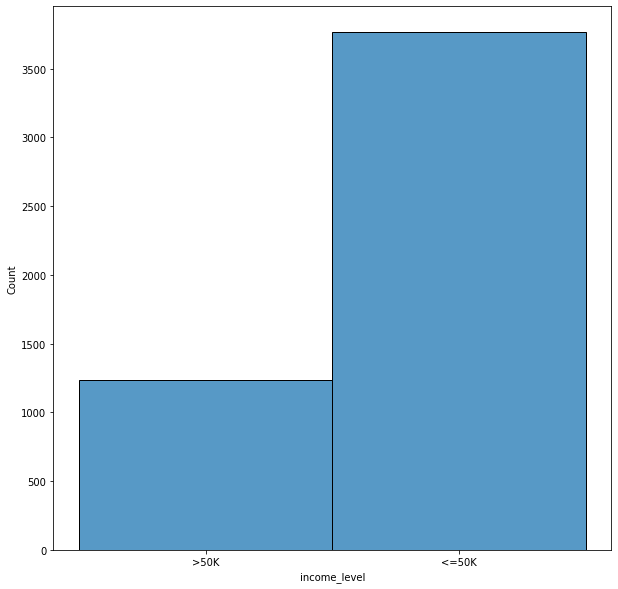

In [ ]:
sns.histplot( x = df['income_level'])
plt.show()

Jak widzimy, nasze dane nie są zbalansowane - będzie to stanowiło utrudnienie w modelowaniu i ograniczenie w użyciu miar oceny jakości klasyfikatorów.

### AutoML

Dzielimy nasze dane na cechy i target

X, y- dane bez modyfikacji
X_sm, y_sm- dane z dodatkowo wygenerowanymi wartościami ">50K" (za pomocą SMOTE)

In [ ]:
X = df_encoded.drop('income_level', axis = 1)
y = df_encoded['income_level']
X_sm,y_sm = transform_SMOTE(X,y)


Tutaj następuje podział na zbiory treningowe i testowe

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, stratify = y)

In [ ]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm)

#### TPOT

In [ ]:
!pip install tpot

In [ ]:
from tpot import TPOTClassifier

In [ ]:
tpot = TPOTClassifier(generations=4,verbosity=2)

tpot.fit(X_train, y_train)



Generation 1 - Current best internal CV score: 0.8345

Generation 2 - Current best internal CV score: 0.8345

Generation 3 - Current best internal CV score: 0.8355

Generation 4 - Current best internal CV score: 0.8355

Best pipeline: RandomForestClassifier(SGDClassifier(input_matrix, alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=0.25, learning_rate=constant, loss=hinge, penalty=elasticnet, power_t=0.0), bootstrap=False, criterion=gini, max_features=0.3, min_samples_leaf=5, min_samples_split=15, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=4,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

#### HyperOptEstimator

In [ ]:
!pip install hyperopt

In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

In [ ]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hyperopt import tpe

In [ ]:
he = HyperoptEstimator(classifier=any_classifier('clf'), algo=tpe.suggest, max_evals=10, trial_timeout=60)
he.fit(X_train,y_train)

100%|██████████| 1/1 [00:03<00:00,  3.43s/it, best loss: 0.17000000000000004]


In [ ]:
print(he.best_model())


{'learner': RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None,
                       max_features=0.25368305867778507, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=245, n_jobs=1, oob_score=False,
                       random_state=4, verbose=False, warm_start=False), 'preprocs': (), 'ex_preprocs': ()}


Jako najlepszy model wskazany został las losowy.

### Funkcje pomocnicze

In [ ]:
#Ta funkcja rysuje ROC i confusion matrix, wypisuje balanced_accuracy, recall i precision
#zwraca cross validaion, można np wykres zrobić, a także tablicę tablic data, dzięki której można np rysować ROC
#X- ramka danych bez targetu
#y- target
#model- model, wcześniej wytrenowany (reprodukcja wyników)
#text- nazwa modelu do tytułu wykresu

def model_testing(X_fun,y_fun, model,text):
    X_train, X_test, y_train, y_test = train_test_split(X_fun, y_fun, test_size=0.2, random_state=42)
    try: #Np svm nie ma funkcji predict_proba
      y_test_score = model.predict_proba(X_test)[:,1]
      y_train_score = model.predict_proba(X_train)[:,1]
    except: 
      y_test_score = model.decision_function(X_test)
      y_train_score = model.decision_function(X_train)
      
    precision_train, recall_train, tr_thresholds = metrics.precision_recall_curve(y_train, y_train_score)
    precision_test, recall_test, te_thresholds = metrics.precision_recall_curve(y_test, y_test_score)
    data = [[precision_train, recall_train], [precision_test, recall_test]]
    labels = ["Train PRC", "Test PRC"]
    #Cross validation
    cross_validation = cross_validate(model, X_fun, y_fun, verbose = 0, cv = 10, scoring = ['accuracy','balanced_accuracy', 'precision', 'recall'])
    #Drawing PRC curve
    draw_PRC(data,labels,text)
    #Drawing confusion matrix
    fig = metrics.plot_confusion_matrix(model,X_test,y_test,display_labels=['<=50K', '>50K'],
                                 cmap=plt.cm.Blues)
    fig.ax_.set_title("Confusion matrix for %s" %text)
    #Cross validation results
    print("Accuracy: Mean:{}, Std:{}".format(np.mean(cross_validation['test_accuracy']), np.std(cross_validation['test_accuracy'])))
    print("\n")
    print("Balanced accuracy: Mean:{}, Std:{}".format(np.mean(cross_validation['test_balanced_accuracy']), np.std(cross_validation['test_balanced_accuracy'])))
    print("\n")
    print("Precision: Mean:{}, Std:{}".format(np.mean(cross_validation['test_precision']), np.std(cross_validation['test_precision'])))
    print("\n")
    print("Recall: Mean:{}, Std:{}".format(np.mean(cross_validation['test_recall']), np.std(cross_validation['test_recall'])))
    return  data[1]

In [ ]:
#Rysuje PRC (przyda się żeby np nałożyć kilka krzywych na siebie później)
#data- tablica tablic zawierających wyniki z predict_proba
#labels- tablica nazw krzywych'
#title- tytuł wykresu

# Zmieniłem na PRC bo podobno lepiej pokazuje niezbalansowane
def draw_PRC(data, labels, title):
  if len(data) != len(labels):
    raise Exception("Labels and data must be the same length")
  plt.grid()
  for i in range(len(data)):
    plt.plot(data[i][0],data[i][1], label = labels[i])
  plt.legend()
  plt.title("PRC plot for {}".format(title))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.rcParams["figure.figsize"] = (10,10)
  print("\n")
  for i in range(len(data)):
    print("AUPRC for {} is {}".format(labels[i], metrics.auc(data[i][1], data[i][0])))
  print("\n")

In [ ]:
#Przekształca dane, tworząc nowe z mniejszego targetu
#X- cechy
#y- target
def transform_SMOTE(X,y):
  sm = SMOTE(random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)
  X_sm = pd.DataFrame(np.vstack(X_sm))
  X_sm.columns = X.columns
  X_sm = X_sm.applymap(lambda x:int(round(x)))
  X_sm['hours_per_week'] = X_sm['hours_per_week'].astype(float)
  y_sm = pd.Series(y_sm)
  y_sm.name ='income_level'
  return X_sm, y_sm

### Testowanie modeli 

#### XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgboost = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6376400671081481, colsample_bynode=1,
              colsample_bytree=0.6710253746119691, gamma=0.08442279441798688,
              learning_rate=0.001411421476438557, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=np.nan, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.007706099078972795, reg_lambda=3.6738184338567113,
              scale_pos_weight=1, seed=4, silent=None,
              subsample=0.726657510571066, verbosity=1)
xgboost_balanced = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6376400671081481, colsample_bynode=1,
              colsample_bytree=0.6710253746119691, gamma=0.08442279441798688,
              learning_rate=0.001411421476438557, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=np.nan, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.007706099078972795, reg_lambda=3.6738184338567113,
              scale_pos_weight=1, seed=4, silent=None,
              subsample=0.726657510571066, verbosity=1)


In [ ]:
# zbalansowane dane
xgboost_balanced.fit(X_train_sm,y_train_sm)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6376400671081481, colsample_bynode=1,
              colsample_bytree=0.6710253746119691, gamma=0.08442279441798688,
              learning_rate=0.001411421476438557, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.007706099078972795, reg_lambda=3.6738184338567113,
              scale_pos_weight=1, seed=4, silent=None,
              subsample=0.726657510571066, verbosity=1)

In [ ]:
# niezbalansowane dane
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6376400671081481, colsample_bynode=1,
              colsample_bytree=0.6710253746119691, gamma=0.08442279441798688,
              learning_rate=0.001411421476438557, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.007706099078972795, reg_lambda=3.6738184338567113,
              scale_pos_weight=1, seed=4, silent=None,
              subsample=0.726657510571066, verbosity=1)



AUPRC for Train PRC is 0.743384296098909
AUPRC for Test PRC is 0.7355161782808399


Accuracy: Mean:0.8320000000000001, Std:0.010237187113655791


Balanced accuracy: Mean:0.7240831030430217, Std:0.01824736760577413


Precision: Mean:0.7273827096069592, Std:0.024096942439465235


Recall: Mean:0.5108510359297143, Std:0.03488735358834608


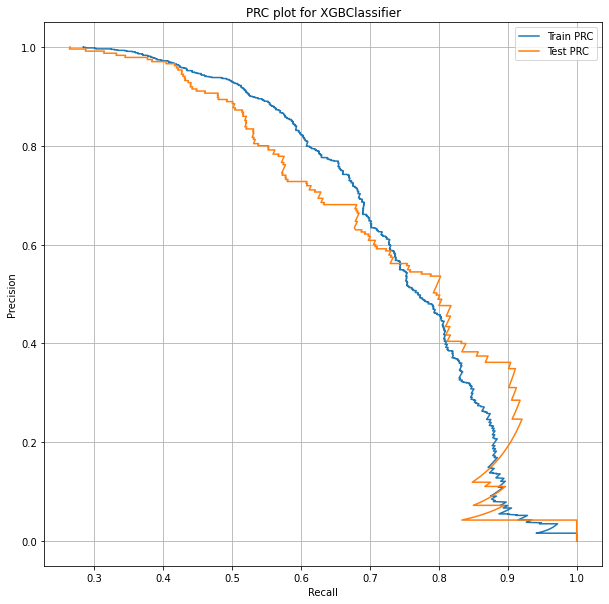

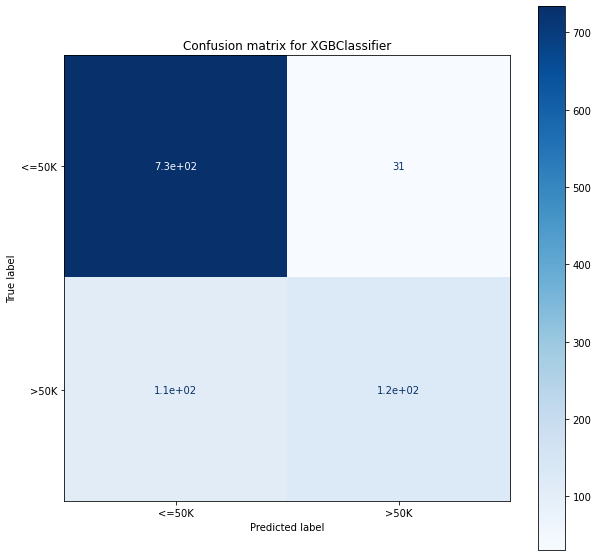

In [ ]:
# ocena jakości modelu wytrenowanego na niezbalansowanych danych
xgb_RPC_data = model_testing(X,y,xgboost, "XGBClassifier")
data = [xgb_RPC_data]



AUPRC for Train PRC is 0.7477211338444381
AUPRC for Test PRC is 0.738688504892318


Accuracy: Mean:0.8320000000000001, Std:0.010237187113655791


Balanced accuracy: Mean:0.7240831030430217, Std:0.01824736760577413


Precision: Mean:0.7273827096069592, Std:0.024096942439465235


Recall: Mean:0.5108510359297143, Std:0.03488735358834608


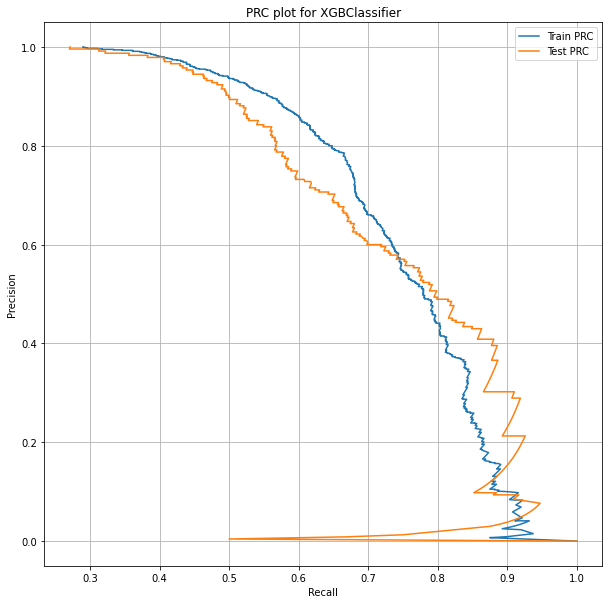

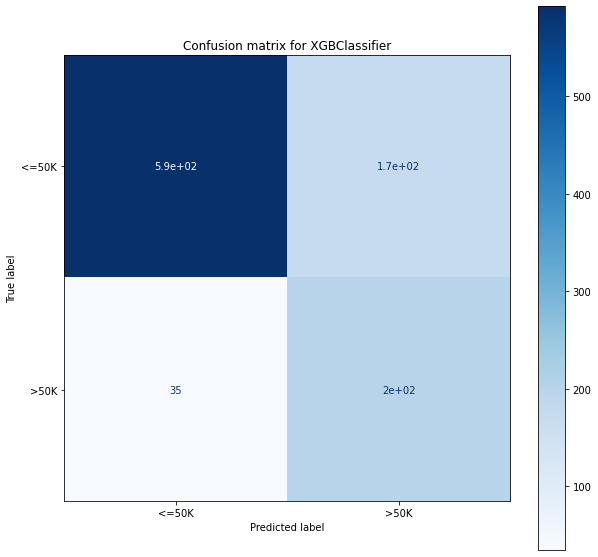

In [ ]:
# ocena jakości modelu wytrenowanego na zbalansowanych danych
xgb_balanced_RPC_data = model_testing(X,y,xgboost_balanced, "XGBClassifier")
data = data + [xgb_balanced_RPC_data]

#### Regresja logistyczna

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
lr_balanced = LogisticRegression()

In [ ]:
# zbalansowane dane
lr_balanced.fit(X_train_sm, y_train_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# niezbalansowane dane
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



AUPRC for Train PRC is 0.7145807147900337
AUPRC for Test PRC is 0.6734093365620358


Accuracy: Mean:0.8315999999999999, Std:0.014609585894199736


Balanced accuracy: Mean:0.742892337506903, Std:0.0223871833963895


Precision: Mean:0.6947541176214524, Std:0.035530621713781706


Recall: Mean:0.5675845790715972, Std:0.039588919614966724


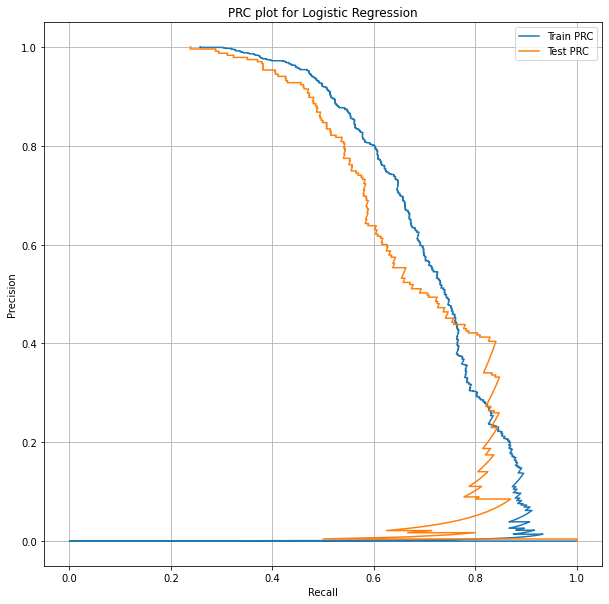

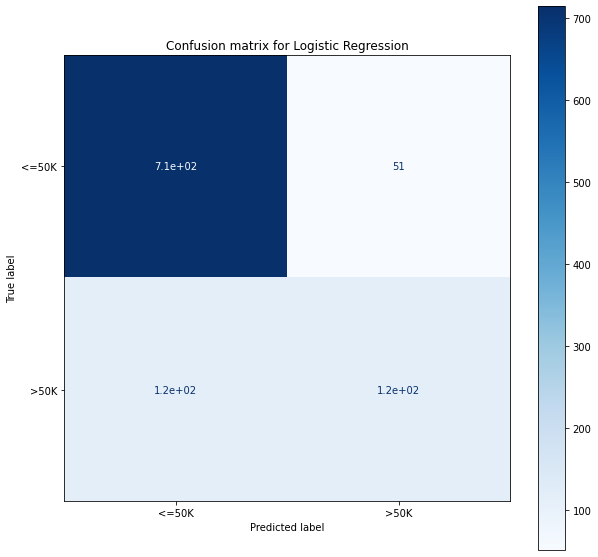

In [ ]:
# ocena jakości modelu wytrenowanego na niexbalansowanych danych
lr_PRC_data = model_testing(X,y,lr, "Logistic Regression")
data = data + [lr_PRC_data]



AUPRC for Train PRC is 0.7135540394330847
AUPRC for Test PRC is 0.6639577917116464


Accuracy: Mean:0.8315999999999999, Std:0.014609585894199736


Balanced accuracy: Mean:0.742892337506903, Std:0.0223871833963895


Precision: Mean:0.6947541176214524, Std:0.035530621713781706


Recall: Mean:0.5675845790715972, Std:0.039588919614966724


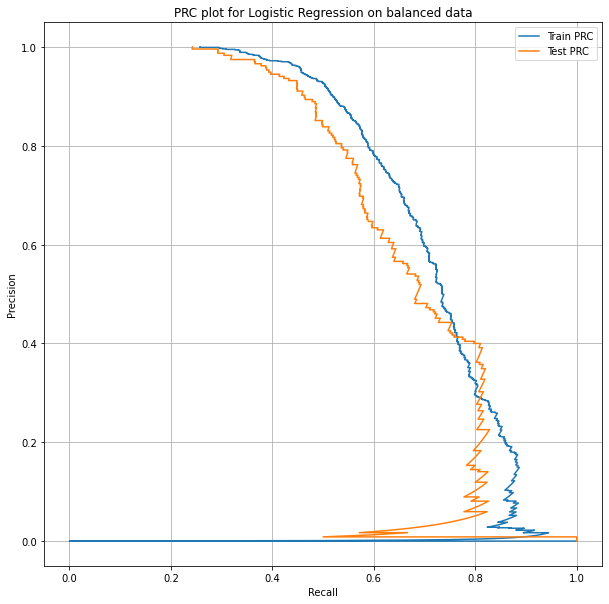

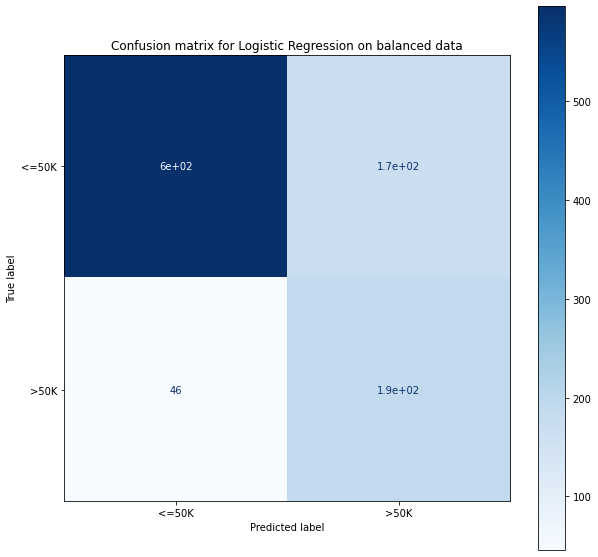

In [ ]:
# ocena jakości modelu wytrenowanego na zbalansowanych danych
lr_balanced_PRC_data = model_testing(X,y,lr_balanced, "Logistic Regression on balanced data")
data = data + [lr_balanced_PRC_data]

#### Drzewo decyzyjne



AUPRC for Train PRC is 0.9155767372829405
AUPRC for Test PRC is 0.8988890071229277


Accuracy: Mean:0.7684, Std:0.01192644121270047


Balanced accuracy: Mean:0.6938693073175586, Std:0.022067997296672238


Precision: Mean:0.5300422415262076, Std:0.023458946921904415


Recall: Mean:0.5465709415158668, Std:0.047475206655409524


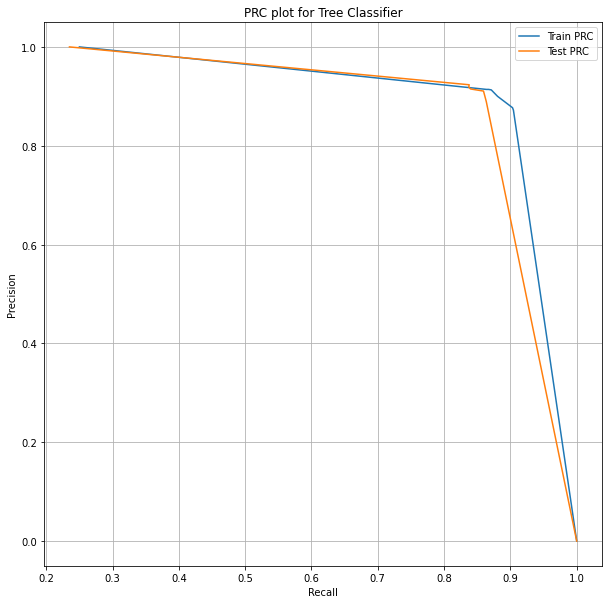

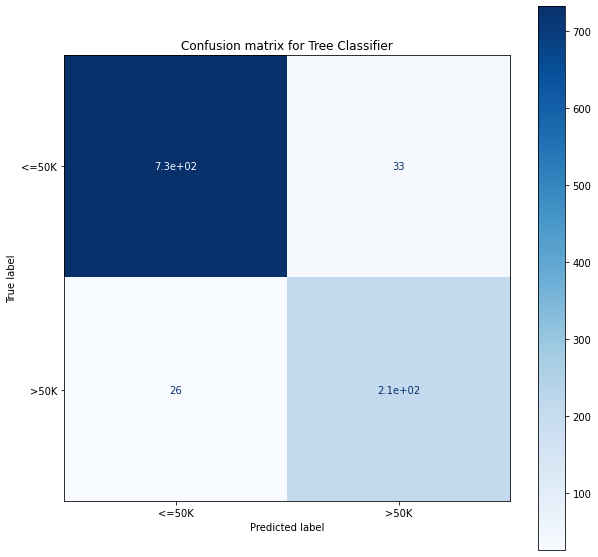

In [ ]:
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier(max_depth = 100)

# niezbalansowane dane
tree_clf = tree_clf.fit(X_train, y_train)
tree_PRC_data = model_testing(X,y,tree_clf, "Tree Classifier")
data = data + [tree_PRC_data]



AUPRC for Train PRC is 0.9347923130493218
AUPRC for Test PRC is 0.9285814680016053


Accuracy: Mean:0.7676000000000001, Std:0.01134195750300627


Balanced accuracy: Mean:0.6925124799543155, Std:0.020141496699792302


Precision: Mean:0.5292505677065377, Std:0.024319340877521065


Recall: Mean:0.5441253606084449, Std:0.04868342705023344


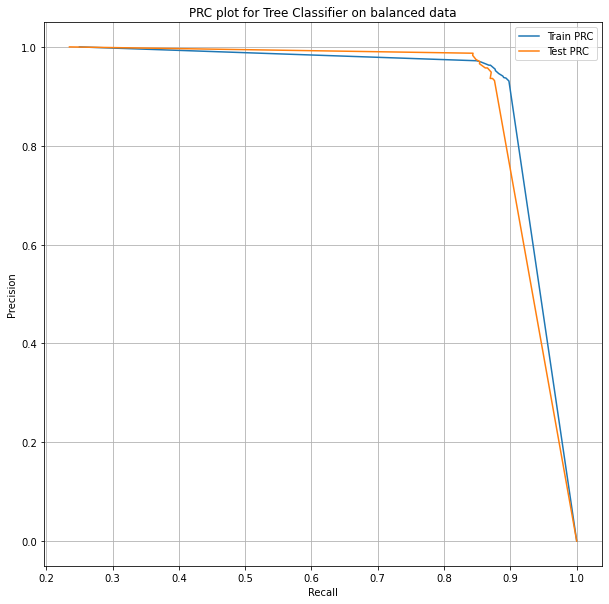

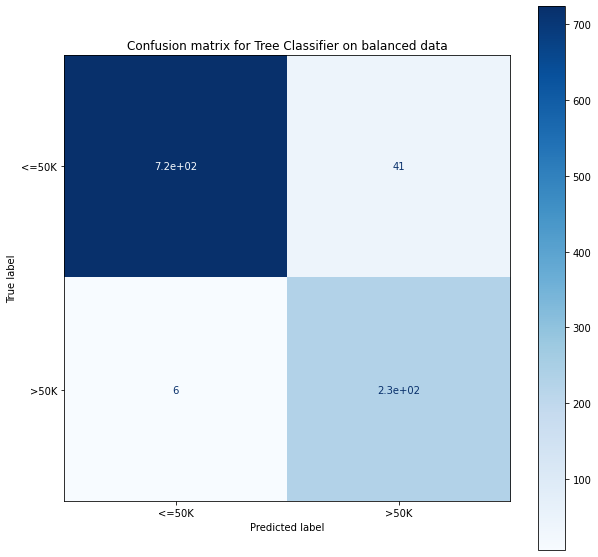

In [ ]:
tree_clf_balanced = tree.DecisionTreeClassifier(max_depth = 100)

# zbalansowane dane
tree_clf_balanced = tree_clf.fit(X_train_sm, y_train_sm)
tree_balanced_PRC_data = model_testing(X,y,tree_clf_balanced, "Tree Classifier on balanced data")
data = data + [tree_balanced_PRC_data]

#### Las losowy



AUPRC for Train PRC is 0.9395984091986754
AUPRC for Test PRC is 0.9211060686787919


Accuracy: Mean:0.8141999999999999, Std:0.013869390758068617


Balanced accuracy: Mean:0.7324324572717782, Std:0.02610171337427185


Precision: Mean:0.6391544810219997, Std:0.03311083049202021


Recall: Mean:0.5708366115919223, Std:0.05694128278406871


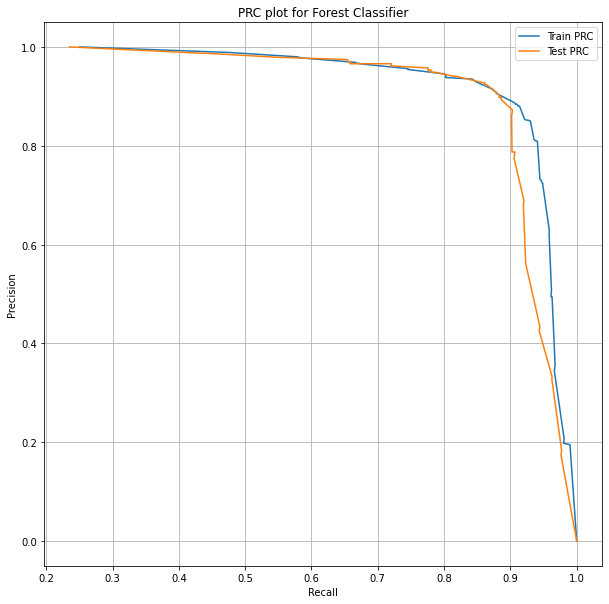

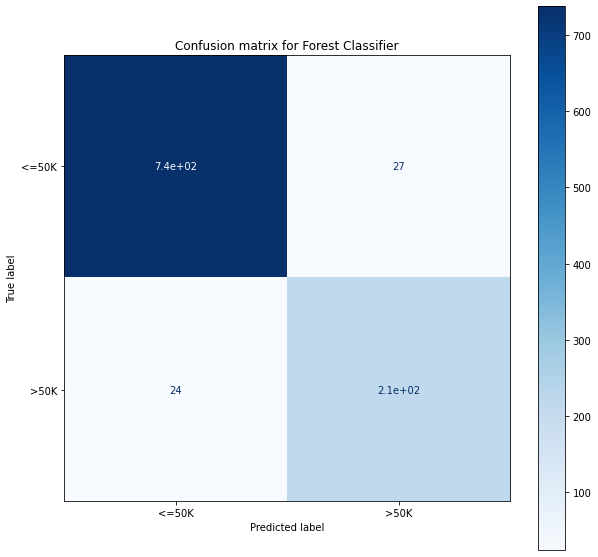

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=15)

# niezbalansowane dane
forest_clf.fit(X_train, y_train)
forest_PRC_data = model_testing(X,y,forest_clf, "Forest Classifier")
data = data + [forest_PRC_data]



AUPRC for Train PRC is 0.9654463578298836
AUPRC for Test PRC is 0.9607736073966594


Accuracy: Mean:0.8134, Std:0.012555476892575568


Balanced accuracy: Mean:0.7308031627530264, Std:0.024214466285278714


Precision: Mean:0.6374563114086863, Std:0.028694622368189288


Recall: Mean:0.5675780225544191, Std:0.052097122143777555


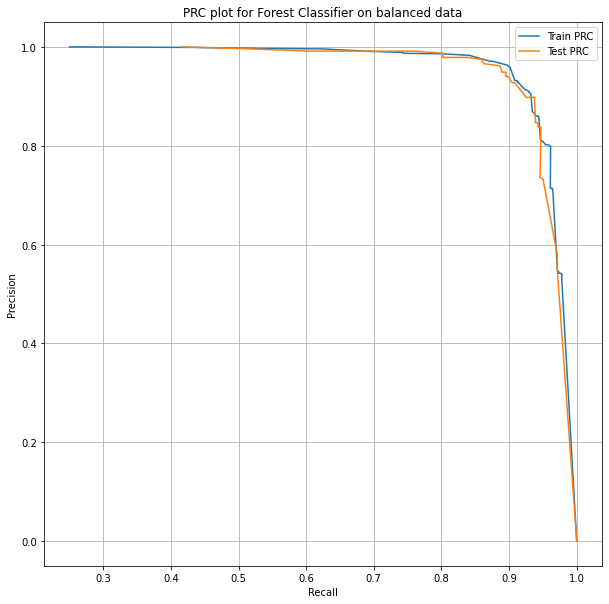

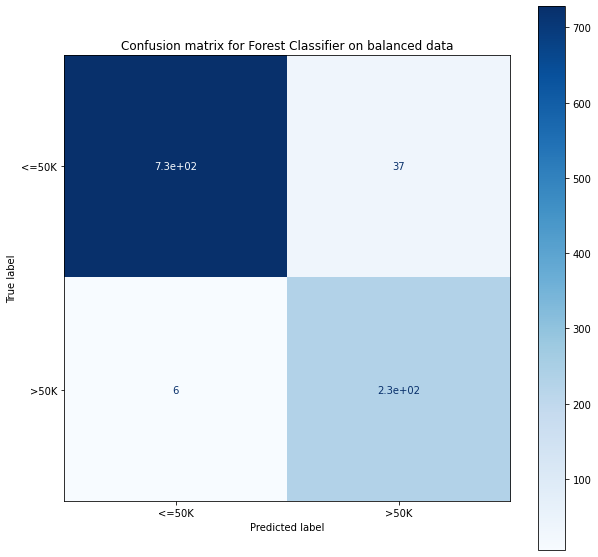

In [ ]:
forest_clf_balanced = RandomForestClassifier(n_estimators=15)

# zbalansowane dane
forest_clf_balanced.fit(X_train_sm, y_train_sm)
forest_balanced_PRC_data = model_testing(X,y,forest_clf_balanced, "Forest Classifier on balanced data")
data = data + [forest_balanced_PRC_data]

### Strojenie parametrów

#### Grid Search

Best: 0.719856 using {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 6}


AUPRC for Train PRC is 0.7205648387025557
AUPRC for Test PRC is 0.7319344425721797


Accuracy: Mean:0.8228, Std:0.014837789592793096


Balanced accuracy: Mean:0.7204972966568297, Std:0.021255735645337417


Precision: Mean:0.690929869646021, Std:0.04782415361528521


Recall: Mean:0.5182795698924731, Std:0.04528505110315922


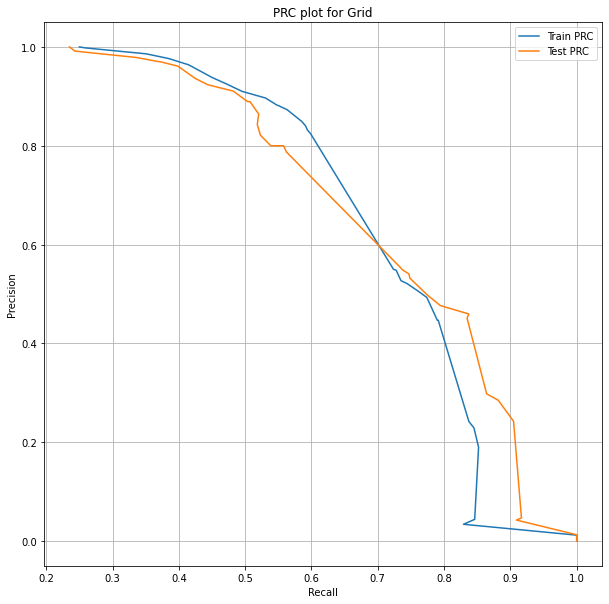

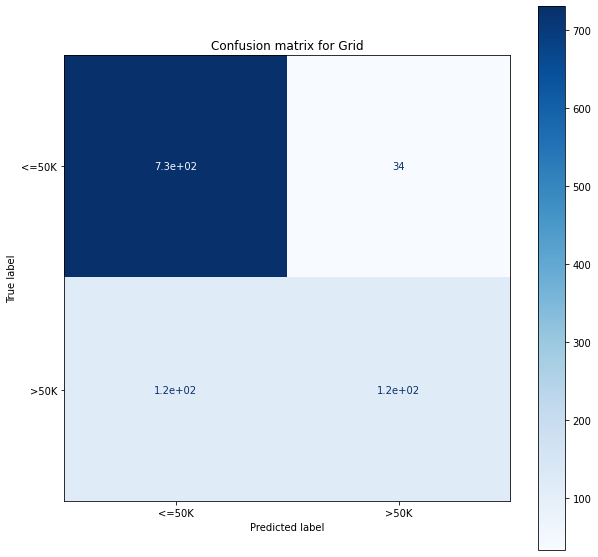

In [ ]:
from sklearn.model_selection import GridSearchCV
max_depth=[3, 5, 6]
criterion=["gini","entrophy"]
ccp_alpha=[0, 0.05]
param_grid = dict(max_depth=max_depth,criterion=criterion, ccp_alpha=ccp_alpha)
tree_model= tree.DecisionTreeClassifier()
grid = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv = 3, n_jobs=-1, scoring = 'balanced_accuracy')
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

grid_PRC_data = model_testing(X,y,grid_result.best_estimator_, "Grid")
data = data + [grid_PRC_data]

#### Random Search

Best: 0.719366 using {'max_depth': 6, 'criterion': 'gini', 'ccp_alpha': 0}


AUPRC for Train PRC is 0.7205648387025557
AUPRC for Test PRC is 0.7319344425721797


Accuracy: Mean:0.8230000000000001, Std:0.015159155649309738


Balanced accuracy: Mean:0.720903447993161, Std:0.02183525929153339


Precision: Mean:0.6912276488296013, Std:0.04815451820000586


Recall: Mean:0.5190925780225545, Std:0.04610975112115387


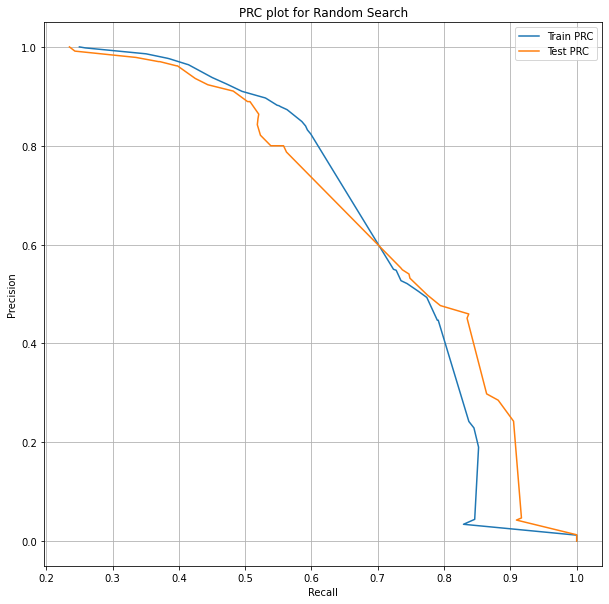

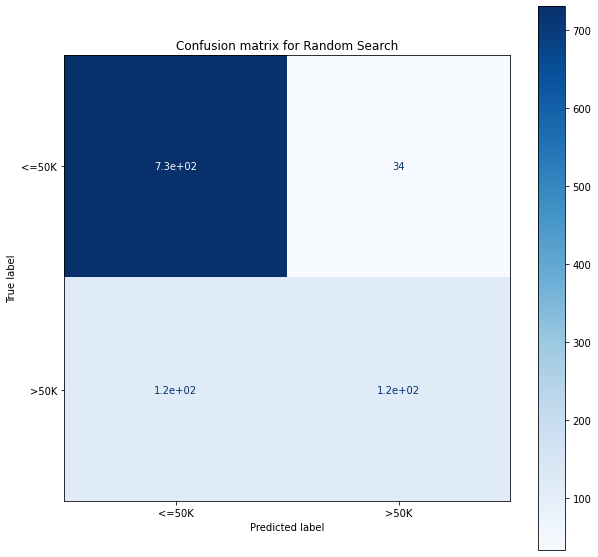

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random = RandomizedSearchCV(estimator=tree_model, param_distributions=param_grid, cv = 3, n_jobs=-1, scoring='balanced_accuracy')
random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

random_PRC_data = model_testing(X,y,random_result.best_estimator_, "Random Search")
data = data + [random_PRC_data]

#### Komitety

Przetestujemy komitet oparty na "miękkim" głosowaniu, stworzony na drzewie decyzyjnym, lesie losowym i xgboost. 

In [ ]:
forest_clf_soft = RandomForestClassifier(n_estimators=15)
tree_model_soft = tree.DecisionTreeClassifier(max_depth= 6, criterion= 'gini', ccp_alpha=0)
xgboost_soft = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6376400671081481, colsample_bynode=1,
              colsample_bytree=0.6710253746119691, gamma=0.08442279441798688,
              learning_rate=0.001411421476438557, max_delta_step=0, max_depth=7,
              min_child_weight=2, missing=np.nan, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.007706099078972795, reg_lambda=3.6738184338567113,
              scale_pos_weight=1, seed=4, silent=None,
              subsample=0.726657510571066, verbosity=1)

In [ ]:
estimators=[('DecisionTree', tree_model_soft), ('RandomForest', forest_clf_soft), ('XGBoost', xgboost_soft)]

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
model_soft = VotingClassifier(estimators=estimators, voting='soft')
model_soft.fit(X_train, y_train)



AUPRC for Train PRC is 0.8855797974449698
AUPRC for Test PRC is 0.884860375290089


Accuracy: Mean:0.8336, Std:0.013230268326832976


Balanced accuracy: Mean:0.7482908113647639, Std:0.023571313240433815


Precision: Mean:0.6956341972868104, Std:0.029550607327802514


Recall: Mean:0.5797141358510359, Std:0.046301173597530235


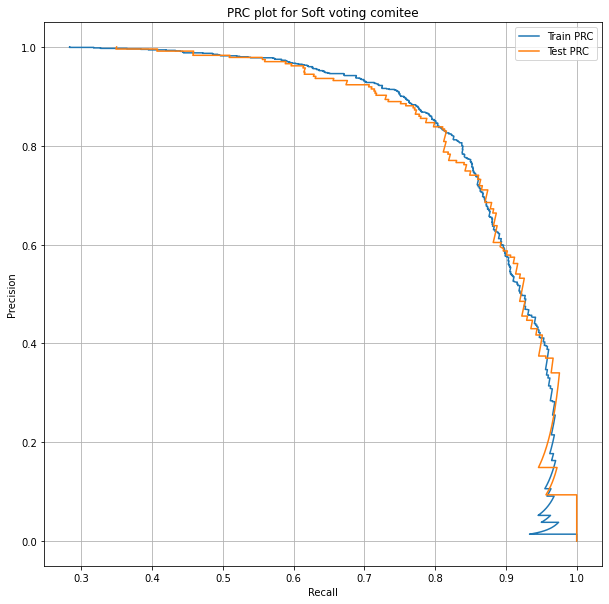

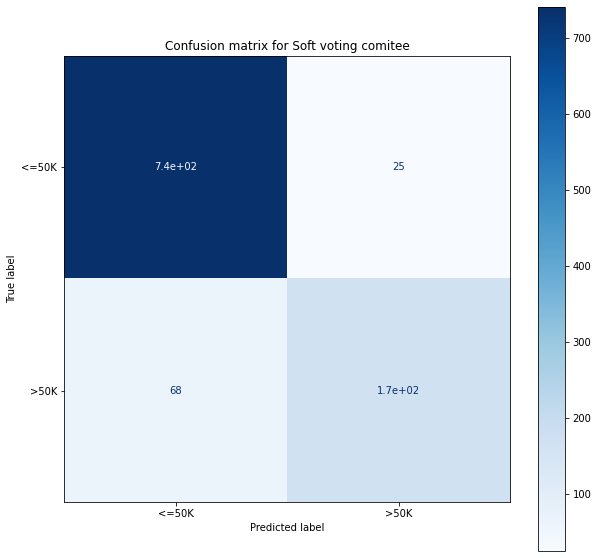

In [ ]:
soft_PRC_data = model_testing(X,y,model_soft,"Soft voting comitee")
data = data + [soft_PRC_data]

In [ ]:
model_soft_balanced = VotingClassifier(estimators=estimators, voting='soft')
model_soft_balanced.fit(X_train_sm, y_train_sm)



AUPRC for Train PRC is 0.9263262229649399
AUPRC for Test PRC is 0.9200955861333395


Accuracy: Mean:0.8308, Std:0.00917387595294378


Balanced accuracy: Mean:0.7439906817012094, Std:0.019554311573421877


Precision: Mean:0.6897823638585824, Std:0.019295780080363603


Recall: Mean:0.5724429583005508, Std:0.04229928762058209


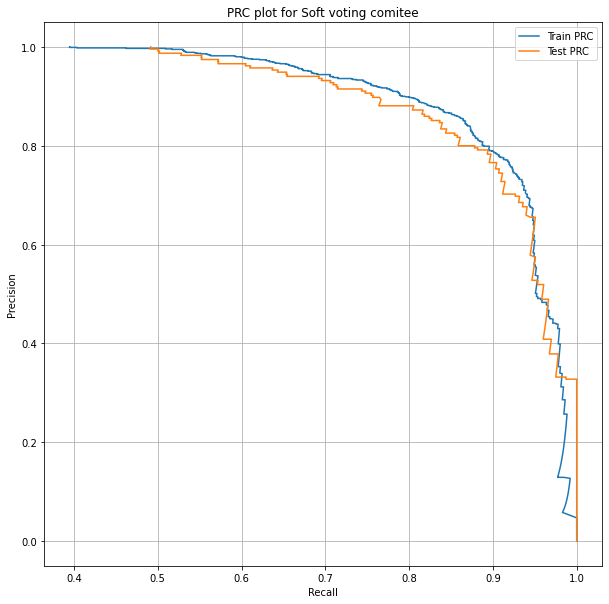

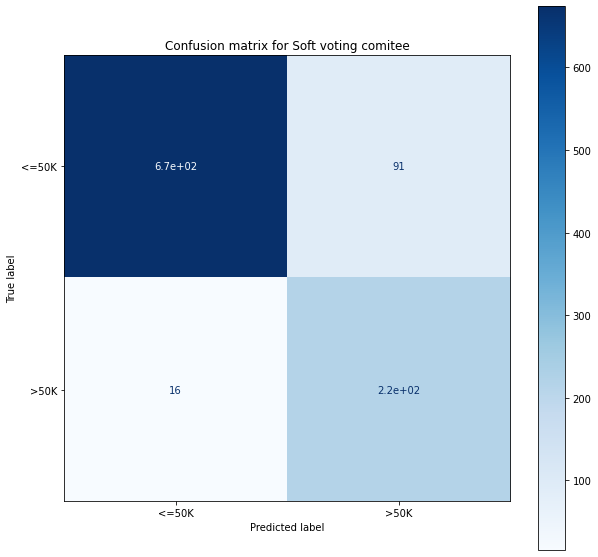

In [ ]:
soft_balanced_PRC_data = model_testing(X,y,model_soft_balanced,"Soft voting comitee")
data = data + [soft_balanced_PRC_data]

### Porównanie modeli

In [ ]:
labels = ['XGBoost','XGBoost balanced', 'Logistic Regression', 
          'Logistic Regression balanced', 'Tree', 'Tree balanced',
          'Forest', 'Forest balanced', 'Grid Search', 'Random Search',
          'Soft model', 'Soft model balanced']



AUPRC for XGBoost is 0.7355161782808399
AUPRC for XGBoost balanced is 0.738688504892318
AUPRC for Logistic Regression is 0.6734093365620358
AUPRC for Logistic Regression balanced is 0.6639577917116464
AUPRC for Tree is 0.8988890071229277
AUPRC for Tree balanced is 0.9285814680016053
AUPRC for Forest is 0.9211060686787919
AUPRC for Forest balanced is 0.9607736073966594
AUPRC for Grid Search is 0.7319344425721797
AUPRC for Random Search is 0.7319344425721797
AUPRC for Soft model is 0.884860375290089
AUPRC for Soft model balanced is 0.9200955861333395




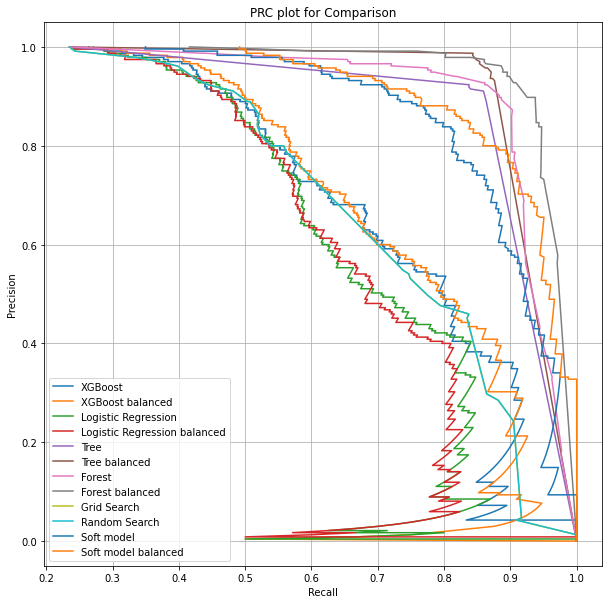

In [ ]:
draw_PRC(data, labels, "Comparison")